In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohamedmaideen/zillow-com-house-price-prediction")

print("Path to dataset files:", path)

In [5]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_excel('/root/.cache/kagglehub/datasets/mohamedmaideen/zillow-com-house-price-prediction/versions/1/Zillow.com House Price Prediction Data.xlsx')
mini_df = df[['url','timeOnZillow', 'longitude', 'latitude', 'price']].dropna()
mini_df['timeOnZillow'] = mini_df['timeOnZillow'].apply(lambda x: int(x.split(' ')[0]))

In [42]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(mini_df, geometry=gpd.points_from_xy(mini_df.longitude, mini_df.latitude))

In [ ]:
gdf = gdf.reset_index(drop=True)

In [43]:
gdf['buffer'] = gdf.geometry.buffer(0.01) # Создает буфер вокруг геометрических объектов, что полезно для анализа близости.

In [53]:
gdf['intersection'] = gdf.loc[0, 'buffer'].intersection(gdf.buffer) # расстояние до точки

In [61]:
joined_gdf = gpd.sjoin(gdf1, gdf2, how='inner') # merge by geopandas

In [ ]:
# поиск ближайшего соседа в датасете и данные по нему

def find_nearest(geometry, gdf):
    distances = gdf.geometry.distance(geometry) # расстояния от данного объекта до всех
    nearest_index = distances[distances.values != 0].idxmin() # Получение индекса (кроме самого себя)
    return gdf.loc[nearest_index, 'geometry'] # ind2vals

gdf['nearest'] = gdf.geometry.apply(lambda geom: find_nearest(geom, gdf))

<Axes: >

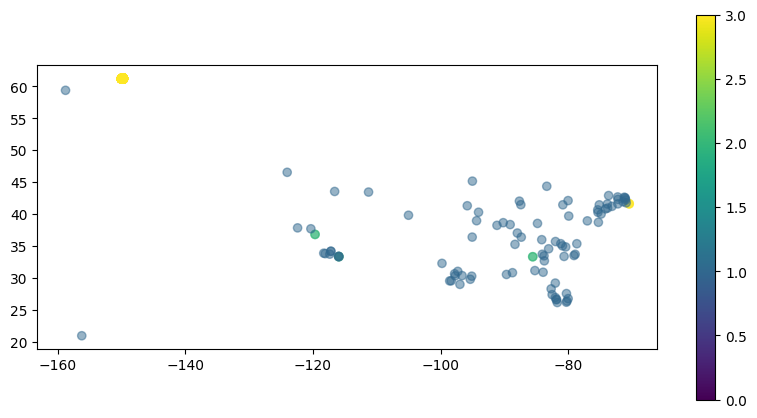

In [217]:
# плотность обёектов
gdf['buffer'] = gdf.geometry.buffer(0.01)
gdf['count'] = gdf.apply(lambda row: gdf.intersects(row.buffer).sum(), axis=1)
gdf['density'] = gdf['count'] / 1 # заменить константу
gdf.plot(column='density', legend=True, cmap='viridis',
         figsize=(10, 5), vmin=0, vmax=3, alpha=0.5)

In [216]:
# geo KNN

from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
# Предполагаем, что gdf уже загружен и содержит необходимые данные

targets = ['price', 'density']

# Создание модели kNN
kNN = KNeighborsClassifier(n_neighbors=5, weights='distance')
kNN.fit(gdf[['longitude', 'latitude']], gdf[targets])

# Получаем индексы ближайших соседей для каждой точки
distances, indices = kNN.kneighbors(gdf[['longitude', 'latitude']], n_neighbors=5)

# Для хранения средних значений предсказаний
average_predictions = []

# Вычисляем средние значения для каждого экземпляра, исключая саму точку
for i in tqdm(range(len(gdf))):
    # Получаем значения целевой переменной от соседей
    neighbor_values = gdf[targets].iloc[indices[i][1:]]  # исключаем первый элемент, который является самой точкой
    neighbor_distances = distances[i][1:]  # расстояния к соседям, исключая первое
    # Заменяем нулевые расстояния на очень маленькое значение
    neighbor_distances = np.where(neighbor_distances == 0, 1e-10, neighbor_distances)
    # Вычисляем средние значения для каждого таргета с весами
    average_value = np.average(neighbor_values, axis=0, weights=1/neighbor_distances)  # используем веса расстояний
    average_predictions.append(average_value)
# Преобразуем в массив NumPy
average_predictions = np.array(average_predictions)
for col in targets:
    gdf[col+'_mean'] = average_predictions[:, targets.index(col)]

100%|██████████| 5593/5593 [00:10<00:00, 545.79it/s]


In [ ]:
color = ['green' if i > 1000 else 'red' for i in gdf.timeOnZillow]
markersize = [i/gdf.price.mean()*10 for i in gdf.price]
gdf.plot(color=color, markersize=markersize, figsize=(10, 10), alpha=0.5)